## Accessing JRC Global Surface Water data with the Planetary Computer STAC API

This dataset contains data that show different facets of the spatial and temporal distribution of surface water over the last 32 years. In this notebook, we'll demonstrate how to access and work with this data through the Planetary Computer.

### Environment setup


In [7]:
from pystac_client import Client
from matplotlib.colors import ListedColormap
import rasterio
import rasterio.mask
import numpy as np
import pystac
import planetary_computer as pc

### Query the dataset

JRC Global Surface Water data on the Planetary Computer is available globally. We'll pick an area with seasonal water in Bangladesh and use the STAC API to find what data items are avaialable.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [91.07803344726562, 24.082828048468436],
            [91.20162963867188, 24.20563707758362],
            [91.43783569335938, 24.463400705082282],
            [91.50238037109375, 24.71315296906617],
            [90.9393310546875, 24.835349273134295],
            [90.81161499023438, 24.648265332632818],
            [90.89813232421875, 24.337086982410497],
            [90.90774536132812, 24.11792837933617],
            [91.07803344726562, 24.082828048468436],
        ]
    ],
}

We can now execute a STAC API query for our selected area:

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
jrc = catalog.search(collections=["jrc-gsw"], intersects=area_of_interest)

items = list(jrc.get_items())

print(f"Returned {len(items)} Items")

Returned 1 Items


A single item is returned, so we can work with single assets. If we chose an area with multiple tiles intersecting, we could save use something like [stacstack](https://github.com/gjoseph92/stackstac) or [gdal.BuildVRT](https://gdal.org/python/osgeo.gdal-module.html#BuildVRT) to work with multiple items and assets as a single layer.

In [4]:
item = items[0]

Let's capture the color maps that are included in the COG assets by reading the metadata of the GeoTIFFs using rasterio. This also converts the color maps into a format matplotlib understands:

In [8]:
cog_assets = [
    asset_key
    for asset_key, asset in item.assets.items()
    if asset.media_type == pystac.MediaType.COG
]

In [12]:
cmaps = {}
for asset_key in cog_assets:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

This defines a method that opens up a COG asset of our item and crops it by our area of interest:

In [13]:
# Downsample the scene for plotting
def read_asset_data(asset_key):
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        out_image, _ = rasterio.mask.mask(
            src, [area_of_interest], crop=True, nodata=255
        )

    return out_image

We can now render the six assets of the JRC Global Surface Water dataset over our area:

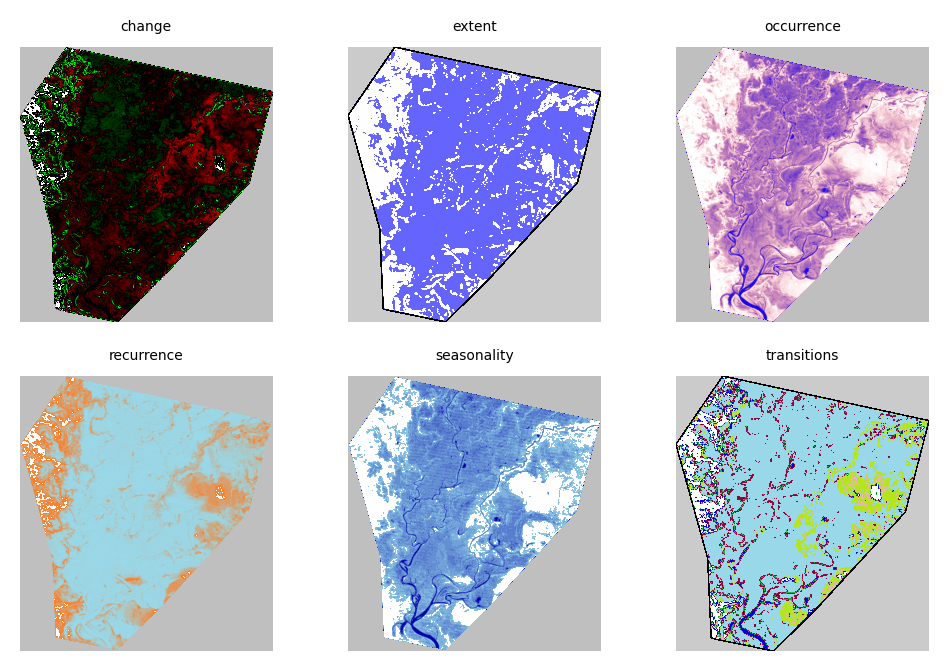

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

dpi = 200
fig = plt.figure(frameon=False, dpi=dpi)

for i, asset_key in enumerate(cog_assets):
    asset_data = read_asset_data(asset_key)
    ax1 = fig.add_subplot(int(f"23{i+1}"))
    ax1.set_title(asset_key, fontdict={"fontsize": 5})
    ax1.set_axis_off()
    plt.imshow(asset_data[0], norm=Normalize(0, 255), cmap=cmaps[asset_key])